In [1]:
import re
import json
import os
import shutil

from datetime import datetime
import IPython.display as ipd

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

import datasets as hfd

import transformers
from transformers import (
    Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments, Trainer
)

import torch
print(torch.cuda.is_available())

True


In [2]:
from src.data_collator import DataCollatorCTCWithPadding
from src.metrics import WerMetric, parse_w2v2_predictions_batched

In [3]:
import logging
logging_format_str = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(format=logging_format_str, level=logging.WARNING)
logger = logging.getLogger('STT')
logger.setLevel(level=logging.DEBUG)

In [4]:
# DATA_ROOT_DP = os.environ['DATA_HOME']
SSD_DATA_ROOT_DP = os.environ['SSD_DATA_HOME']

In [5]:
CV_PROCESSED_2_DP = f'{SSD_DATA_ROOT_DP}/datasets/cv-corpus-8.0-2022-01-19__be__processed__2'

In [6]:
ds = hfd.load_from_disk(CV_PROCESSED_2_DP)
ds

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 314305
    })
    dev: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15803
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15801
    })
})

In [7]:
# # select subset of data
# ds['train'] = ds['train'].select(range(300))
# ds['dev'] = ds['dev'].select(range(100))
# ds

In [8]:
processor = Wav2Vec2Processor.from_pretrained('artifacts/processor')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [10]:
wer_metric = WerMetric(processor=processor)

In [11]:
vocab = processor.tokenizer.get_vocab()
pd.Series(vocab).to_frame().T

,',i,а,б,в,г,д,е,ж,з,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,ы,ь,э,ю,я,ё,і,ў,|,[UNK],[PAD],<s>,</s>
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,0,35,36,37,38


In [12]:
vocab_size = len(processor.tokenizer.get_vocab())
logger.info(f'vocab_size: {vocab_size}')

2022-03-31 21:11:16,726:STT:INFO:vocab_size: 39


## prepare for training

In [13]:
pretrained_checkpoint_dp = 'train/run_2/2022-03-30-01-26-34/checkpoint-6480'
print(os.listdir(pretrained_checkpoint_dp))

['scheduler.pt', 'preprocessor_config.json', 'training_args.bin', 'pytorch_model.bin', 'scaler.pt', 'config.json', 'rng_state.pth', 'optimizer.pt', 'trainer_state.json']


In [14]:
# model = Wav2Vec2ForCTC.from_pretrained(
#     "facebook/wav2vec2-base",
#     ctc_loss_reduction="mean", 
#     pad_token_id=processor.tokenizer.pad_token_id,
#     vocab_size=vocab_size
# )

In [15]:
# continue from checkpoint
model = Wav2Vec2ForCTC.from_pretrained(pretrained_checkpoint_dp)

In [ ]:
model.freeze_feature_extractor()

In [17]:
model.device

device(type='cpu')

In [18]:
now_str = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

train_out_dp = os.path.join('train', now_str)
os.makedirs(train_out_dp, exist_ok=True)
print(f'will save train output to: "{train_out_dp}"')

logs_dp = os.path.join(train_out_dp, 'logs')
print(f'will save train logs to: "{logs_dp}"')

will save train output to: "train/2022-03-31-10-42-03"
will save train logs to: "train/2022-03-31-10-42-03/logs"


In [19]:
steps = 1080

training_args = TrainingArguments(
    output_dir=train_out_dp,
    logging_dir=logs_dp,

    num_train_epochs=1,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',
    eval_steps=steps,
    logging_steps=steps,
    save_steps=steps,
    save_total_limit=None,
    load_best_model_at_end=True,
    metric_for_best_model='wer',
    greater_is_better=False,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    group_by_length=False,
    gradient_checkpointing=True, 
    
    learning_rate=1e-4,
    weight_decay=0.005,
    warmup_steps=1080,
)

In [20]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=wer_metric.compute_metrics,
    train_dataset=ds['train'],
    eval_dataset=ds['dev'],
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


## train

In [ ]:
trainer.train()

In [24]:
torch.cuda.empty_cache()

## evaluate

In [13]:
finetuned_checkpoint_dp = 'train/run_3/2022-03-31-10-42-03/checkpoint-6480'
print(f'reading model from: "{finetuned_checkpoint_dp}"')
model = Wav2Vec2ForCTC.from_pretrained(finetuned_checkpoint_dp)
model.to('cuda');

reading model from: "train/run_3/2022-03-31-10-42-03/checkpoint-6480"


In [14]:
training_args = TrainingArguments(
    output_dir='eval_output',
    per_device_eval_batch_size=16,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=wer_metric.compute_metrics,
    tokenizer=processor.feature_extractor,
)

### dev set

In [ ]:
pred_out = trainer.predict(ds['dev'])

In [16]:
pred_out.metrics

{'test_loss': 0.12520498037338257,
 'test_wer': 0.19368918940367919,
 'test_runtime': 495.5591,
 'test_samples_per_second': 31.889,
 'test_steps_per_second': 0.666}

In [17]:
print(f"WER on Dev set using Acoustic Model only: {pred_out.metrics['test_wer'] :.4f}")

WER on Dev set using Acoustic Model only: 0.1937


### test set

In [ ]:
pred_out = trainer.predict(ds['test'])

In [16]:
pred_out.metrics

{'test_loss': 0.13471770286560059,
 'test_wer': 0.2066312255176273,
 'test_runtime': 547.2573,
 'test_samples_per_second': 28.873,
 'test_steps_per_second': 0.603}

In [17]:
print(f"WER on Test set using Acoustic Model only: {pred_out.metrics['test_wer'] :.3f}")

WER on Test set using Acoustic Model only: 0.207


### examples of model predictions

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1);

In [19]:
parsed_preds = parse_w2v2_predictions_batched(pred_out, processor=processor)

In [21]:
df_results = pd.DataFrame(parsed_preds)[['text', 'pred_text']]
print(df_results.shape)

df_results['success'] = (df_results['text'] == df_results['pred_text']).astype('int')
df_results['wer'] = df_results.apply(
    lambda row: 
    wer_metric.wer_metric.compute(
        predictions=[row['pred_text']],
        references=[row['text']]
    ),
    axis=1
)

df_results.head()

(15801, 2)


,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.000000
1,быў разбураны пры вызваленні горада ад нямецкафашысцкіх захопнікаў,быў разбураны пры вызваленні горада ад нямецкую фашызцкіх захокнікаў,0,0.375000
2,далейшае супрацоўніцтва паміж нямецкім і савецкім прыняло форму абмену польскіх ваеннапалонных,далейшае супрацоніцтва мічнямецкім савецкім пыняа форамуў абменну польскіх твуеннапога,0,0.727273
3,цвіценне працягваецца з мая да позняй восені,цвіценне працягваецца з мая да позняй восені,1,0.000000
4,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,1,0.000000


In [22]:
success_stats = df_results['success'].value_counts(dropna=False, normalize=True)
success_stats = success_stats.to_frame('fraction').join(
    df_results['success'].value_counts(dropna=False).rename('abs')
)
success_stats

,fraction,abs
0,0.665464,10515
1,0.334536,5286


In [23]:
print(f'Rate of fully recognized clips from Test set using Acoustic Model only: '
      f"{success_stats.loc[1, 'fraction'] :.3%}")

Rate of fully recognized clips from Test set using Acoustic Model only: 33.454%


In [24]:
df_results.sort_values('wer', ascending=False).head()

,text,pred_text,success,wer
4902,і госці шчыра весяліліся,і вось ці ш чырамі сяліліся,0,1.250000
3386,знойдзены статуэткі мужчын і жанчын,зной дзе на статуэткі мужчыны жанцын,0,1.200000
848,дзякуючы агульнай атмасферы нейкай роднаснасці,дзякуй чы агульнаць на сферы нейкай роднасці,0,1.200000
55,нешматлікія насарогі гепарды жырафы пітоны,жмалязя на памазе азапанемі затазанзаю ступон,0,1.200000
13492,азаранка здабыла дзевятнаццаты тытул у кар'еры,а зарнка зда была дзевятна стытытул і кар'еры,0,1.166667


In [25]:
df_results.sort_values('wer', ascending=True).head()

,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.0
8299,папершае цудоўны залацісты колер,папершае цудоўны залацісты колер,1,0.0
8298,наш камітэт павінен гэтаму паспрыяць,наш камітэт павінен гэтаму паспрыяць,1,0.0
8297,стары будынак царквы быў цалкам разабраны,стары будынак царквы быў цалкам разабраны,1,0.0
8288,ну я вывучу штонебудзь калі нас яшчэ паклічуць,ну я вывучу штонебудзь калі нас яшчэ паклічуць,1,0.0


In [26]:
df_results.iloc[[12, 9532, 9533,12305]]

,text,pred_text,success,wer
12,толькі ў раёне таксама нашы людзі вясковыя,толькі ў раёне таксама наш людзі вясковыя,0,0.142857
9532,у яго нават ёсць сольныя выступы,у яго нават ёсць сёльныя выступы,0,0.166667
9533,на ўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,наўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,0,0.222222
12305,шлюбам папярэднічалі перагаворы паміж сем'ямі,шлюбам папярэднічалі перагаворы паміж сем'ямі,1,0.000000


### wer stats for test set items

count    15801.000000
mean         0.200231
std          0.203747
min          0.000000
25%          0.000000
50%          0.166667
75%          0.333333
max          1.250000
Name: wer, dtype: float64

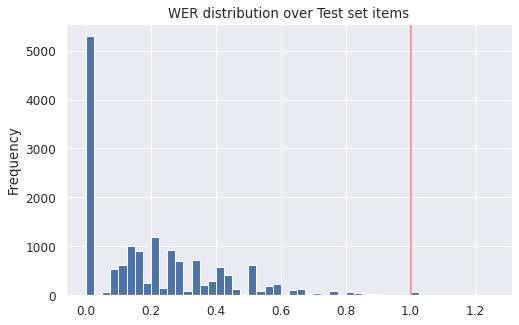

In [27]:
display(df_results['wer'].describe())

df_results['wer'].plot.hist(bins=50, figsize=(8, 5));
plt.title('WER distribution over Test set items');
plt.axvline(1, color='red', alpha=0.5);